In [1]:
!pip install shap
!pip install lime
!pip install keras-tcn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c88a75889acea3e9dac565f44c312524a601672d09c1cb6659f60b45675de927
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import shap
import lime
import lime.lime_tabular
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tcn import TCN
import pandas as pd
import shap
import lime
import lime.lime_tabular
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tcn import TCN

In [3]:
# Define individual paths for each file
X_train_path = '/content/X_train.txt'
y_train_path = '/content/y_train.txt'
X_test_path = '/content/X_test.txt'
y_test_path = '/content/y_test.txt'

# Load data from the paths
X_train = pd.read_csv(X_train_path, delim_whitespace=True, header=None)
y_train = pd.read_csv(y_train_path, delim_whitespace=True, header=None)
X_test = pd.read_csv(X_test_path, delim_whitespace=True, header=None)
y_test = pd.read_csv(y_test_path, delim_whitespace=True, header=None)

# Display shapes of the data
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')


<ipython-input-3-b1e7e34958fc>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(X_train_path, delim_whitespace=True, header=None)
<ipython-input-3-b1e7e34958fc>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv(y_train_path, delim_whitespace=True, header=None)
<ipython-input-3-b1e7e34958fc>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(X_test_path, delim_whitespace=True, header=None)


X_train shape: (7352, 561), y_train shape: (7352, 1)
X_test shape: (2947, 561), y_test shape: (2947, 1)


<ipython-input-3-b1e7e34958fc>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_test = pd.read_csv(y_test_path, delim_whitespace=True, header=None)


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming X_train, X_test, y_train, y_test are already defined from previous steps

# Combine X_train and X_test for easier preprocessing
data_train = X_train.copy()
data_test = X_test.copy()

# Add accelerometer magnitude feature
data_train['acc_magnitude'] = np.sqrt(data_train.iloc[:, 0]**2 + data_train.iloc[:, 1]**2 + data_train.iloc[:, 2]**2)
data_test['acc_magnitude'] = np.sqrt(data_test.iloc[:, 0]**2 + data_test.iloc[:, 1]**2 + data_test.iloc[:, 2]**2)

# Ensure column names are strings to avoid mixed-type issues
data_train.columns = data_train.columns.astype(str)
data_test.columns = data_test.columns.astype(str)

# Standardize the data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(data_train)
X_test_standardized = scaler.transform(data_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values.ravel())
y_test_encoded = label_encoder.transform(y_test.values.ravel())

# Print the shapes of the standardized data and encoded labels
print(f"X_train_standardized shape: {X_train_standardized.shape}, y_train_encoded shape: {y_train_encoded.shape}")
print(f"X_test_standardized shape: {X_test_standardized.shape}, y_test_encoded shape: {y_test_encoded.shape}")


X_train_standardized shape: (7352, 562), y_train_encoded shape: (7352,)
X_test_standardized shape: (2947, 562), y_test_encoded shape: (2947,)


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Convert all columns to numeric, coercing errors to NaN
data_train = data_train.apply(pd.to_numeric, errors='coerce')
data_test = data_test.apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling them with the column mean
data_train.fillna(data_train.mean(), inplace=True)
data_test.fillna(data_test.mean(), inplace=True)

# Convert all column names to strings to avoid mixed data types
data_train.columns = data_train.columns.astype(str)
data_test.columns = data_test.columns.astype(str)

# Verify that there are no NaN values
print(data_train.isna().sum())

# Standardize the data
scaler = StandardScaler()

# Apply standardization to both training and test data
X_train_standardized = scaler.fit_transform(data_train)
X_test_standardized = scaler.transform(data_test)

# Check the shape of the standardized data
print(X_train_standardized.shape, X_test_standardized.shape)


0                0
1                0
2                0
3                0
4                0
                ..
557              0
558              0
559              0
560              0
acc_magnitude    0
Length: 562, dtype: int64
(7352, 562) (2947, 562)


In [6]:
# Check column names and their types
print(data_train.columns)


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '552', '553', '554', '555', '556', '557', '558', '559', '560',
       'acc_magnitude'],
      dtype='object', length=562)


In [7]:
# Convert column names to strings (if not already)
data_train.columns = data_train.columns.astype(str)
data_test.columns = data_test.columns.astype(str)

# Verify the column names
print(data_train.columns)


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '552', '553', '554', '555', '556', '557', '558', '559', '560',
       'acc_magnitude'],
      dtype='object', length=562)


In [8]:
# Check if there are any non-numeric values and convert them to NaN
data_train = data_train.apply(pd.to_numeric, errors='coerce')
data_test = data_test.apply(pd.to_numeric, errors='coerce')

# Verify that all columns are numeric
print(data_train.dtypes)


0                float64
1                float64
2                float64
3                float64
4                float64
                  ...   
557              float64
558              float64
559              float64
560              float64
acc_magnitude    float64
Length: 562, dtype: object


In [9]:
# Handle NaN values (e.g., by filling with the column mean or dropping them)
data_train = data_train.fillna(data_train.mean())
data_test = data_test.fillna(data_test.mean())

# Verify the changes
print(data_train.isna().sum())


0                0
1                0
2                0
3                0
4                0
                ..
557              0
558              0
559              0
560              0
acc_magnitude    0
Length: 562, dtype: int64


In [10]:
# Now apply StandardScaler
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(data_train)
X_test_standardized = scaler.transform(data_test)

# Check the result
print(X_train_standardized.shape, X_test_standardized.shape)


(7352, 562) (2947, 562)


In [11]:
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense
#from tensorflow.keras.optimizers import Adam

# Define the model using Conv1D with dilation
#input_layer = Input(shape=(X_train_standardized.shape[1], 1))

# Temporal convolution with dilation
#x = Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(input_layer)
#x = Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(x)
#x = Conv1D(filters=64, kernel_size=3, dilation_rate=4, activation='relu')(x)
#x = Conv1D(filters=64, kernel_size=3, dilation_rate=8, activation='relu')(x)

# Add Dropout and Dense layers
#x = Dropout(0.5)(x)
#x = Dense(32, activation='relu')(x)
#output_layer = Dense(len(np.unique(y_train_encoded)), activation='softmax')(x)

# Compile the model
#model = Model(inputs=input_layer, outputs=output_layer)
#model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape the input data to 3D (samples, timesteps, features)
#X_train_3d = X_train_standardized.reshape(X_train_standardized.shape[0], X_train_standardized.shape[1], 1)
#X_test_3d = X_test_standardized.reshape(X_test_standardized.shape[0], X_test_standardized.shape[1], 1)

# Display the model summary
#model.summary()


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define the model using Conv1D with dilation
input_layer = Input(shape=(X_train_standardized.shape[1], 1))

# Temporal convolution with dilation
x = Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(input_layer)
x = Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, dilation_rate=4, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, dilation_rate=8, activation='relu')(x)

# Add Dropout and Flatten layer
x = Dropout(0.5)(x)
x = Flatten()(x)  # Flatten the output to match the shape of the labels
x = Dense(32, activation='relu')(x)
output_layer = Dense(len(np.unique(y_train_encoded)), activation='softmax')(x)

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape the input data to 3D (samples, timesteps, features)
X_train_3d = X_train_standardized.reshape(X_train_standardized.shape[0], X_train_standardized.shape[1], 1)
X_test_3d = X_test_standardized.reshape(X_test_standardized.shape[0], X_test_standardized.shape[1], 1)

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train_3d, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 562, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 560, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 556, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 548, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 532, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 532, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 34048)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       1,089,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,078 (4.30 MB)

 Trainable params: 1,127,078 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.7467 - loss: 0.5604 - val_accuracy: 0.9483 - val_loss: 0.1306
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9712 - loss: 0.0839 - val_accuracy: 0.9402 - val_loss: 0.1470
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9819 - loss: 0.0478 - val_accuracy: 0.9477 - val_loss: 0.1636
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9860 - loss: 0.0406 - val_accuracy: 0.9409 - val_loss: 0.1751
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9904 - loss: 0.0277 - val_accuracy: 0.9470 - val_loss: 0.1832
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9919 - loss: 0.0243 - val_accuracy: 0.9511 - val_loss: 0.1797
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9896 - loss: 0.0221 - val_accuracy: 0.9524 - val_loss: 0.1799
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9921 - loss: 0.0237 - val_accuracy: 

In [13]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_3d, y_test_encoded, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")


93/93 - 1s - 7ms/step - accuracy: 0.9494 - loss: 0.1908
Test accuracy: 94.94%


In [14]:
import shap
import numpy as np
import pandas as pd

# Define a function to make predictions using the TCN model
#def tcn_predict(X):
    # Reshape the input to match the expected 3D input shape for the TCN model
#    X_3d = X.reshape((-1, X_train_3d.shape[1], X_train_3d.shape[2]))
#    return model.predict(X_3d)

# Initialize SHAP explainer using a sample of the training data
#explainer = shap.KernelExplainer(tcn_predict, shap.sample(X_train_standardized, 100))

# Generate a sample of the test data for SHAP explanations
#sample_indices = np.random.choice(X_test_standardized.shape[0], 100)
#sample = X_test_standardized[sample_indices]

# Convert sample to DataFrame for SHAP compatibility
#sample_df = pd.DataFrame(sample, columns=[str(col) for col in range(sample.shape[1])])

# Calculate SHAP values for the sample
#shap_values = explainer.shap_values(sample)

# Plot the SHAP summary plot
#shap.summary_plot(shap_values, sample_df, plot_type="bar", plot_size=(12, 8))


In [15]:
import shap
import numpy as np
import pandas as pd

# Define a function to make predictions using the TCN model
def tcn_predict(X):
    # Reshape the input to match the expected 3D input shape for the TCN model
    X_3d = X.reshape((-1, X_train_3d.shape[1], X_train_3d.shape[2]))
    return model.predict(X_3d)

# Initialize SHAP explainer using a sample of the training data
explainer = shap.KernelExplainer(tcn_predict, shap.sample(X_train_standardized, 100))

# Generate a sample of the test data for SHAP explanations
sample_indices = np.random.choice(X_test_standardized.shape[0], 100)
sample = X_test_standardized[sample_indices]

# Convert sample to DataFrame with feature names as columns
feature_names = [f"Feature {i+1}" for i in range(sample.shape[1])]
sample_df = pd.DataFrame(sample, columns=feature_names)

# Calculate SHAP values for the sample
shap_values = explainer.shap_values(sample)




4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9913/9913 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━

<Figure size 1800x1200 with 0 Axes>

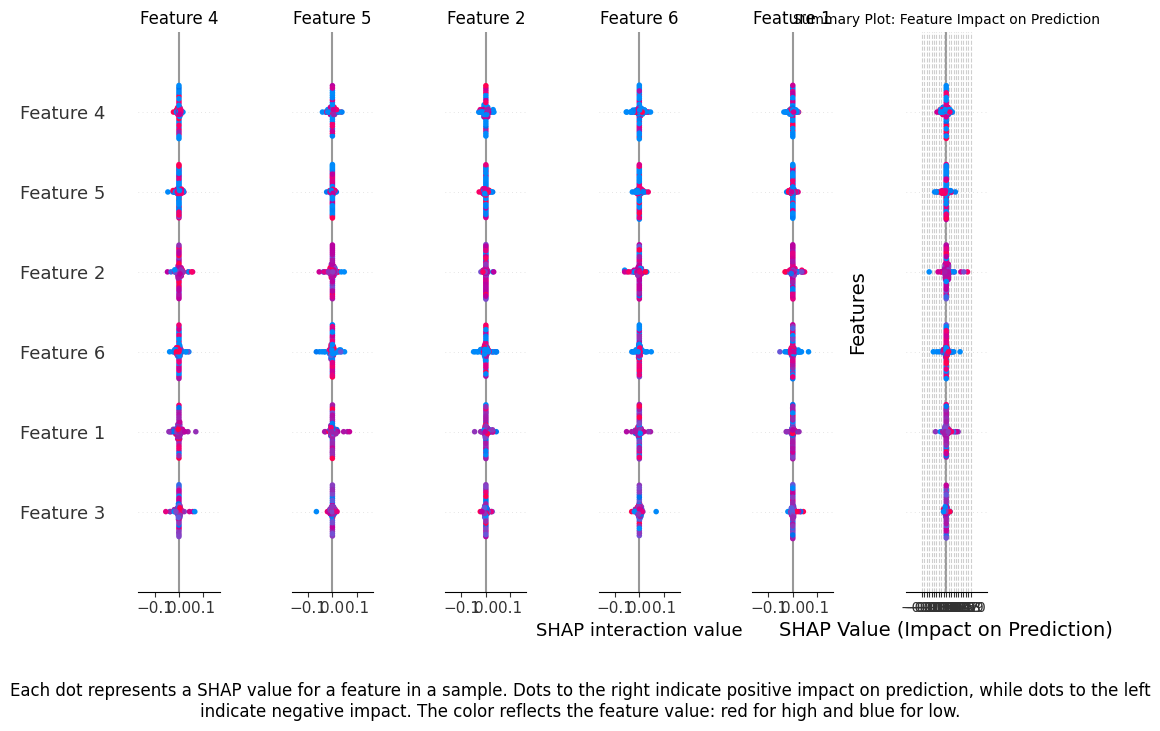

In [75]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# Set up the figure size for better readability
plt.figure(figsize=(18, 12))  # Increase the figure size for clarity

# Generate the SHAP summary plot with adjusted parameters for better visibility
shap.summary_plot(
    shap_values,
    sample_df,
    plot_type="dot",  # Dot plot for SHAP values
    alpha=0.7,        # Set transparency for dots
    color='coolwarm', # Set a visually distinct color map
    show=False         # Prevent the plot from displaying until we make further adjustments
)

# Adjust the axis labels, title, and ticks for better readability
plt.title("Summary Plot: Feature Impact on Prediction", fontsize=10)  # Title for the plot
plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=14)  # Label for the x-axis
plt.ylabel("Features", fontsize=14)  # Label for the y-axis

# Customize tick labels
plt.xticks(np.arange(-0.1, 0.11, 0.01), fontsize=10)  # Customize x-axis ticks with better spacing and size
plt.yticks(fontsize=12)  # Customize y-axis ticks

# Add grid for clarity
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Adjust space at the bottom to prevent overlap
plt.subplots_adjust(bottom=0.2)  # Increase bottom space further to prevent overlap with the annotation

# Add a custom annotation to explain the dots more clearly
plt.figtext(0.5, -0.09,
            "Each dot represents a SHAP value for a feature in a sample. "
            "Dots to the right indicate positive impact on prediction, while "
            "dots to the left indicate negative impact. The color reflects the "
            "feature value: red for high and blue for low.",
            ha='center', fontsize=12, wrap=True)

# Ensure layout adjustment to avoid overlap
plt.tight_layout()

# Show the plot with the adjustments
plt.show()



Adjusted Feature SHAP values shape: (100, 10)
Feature values shape: (100, 10)


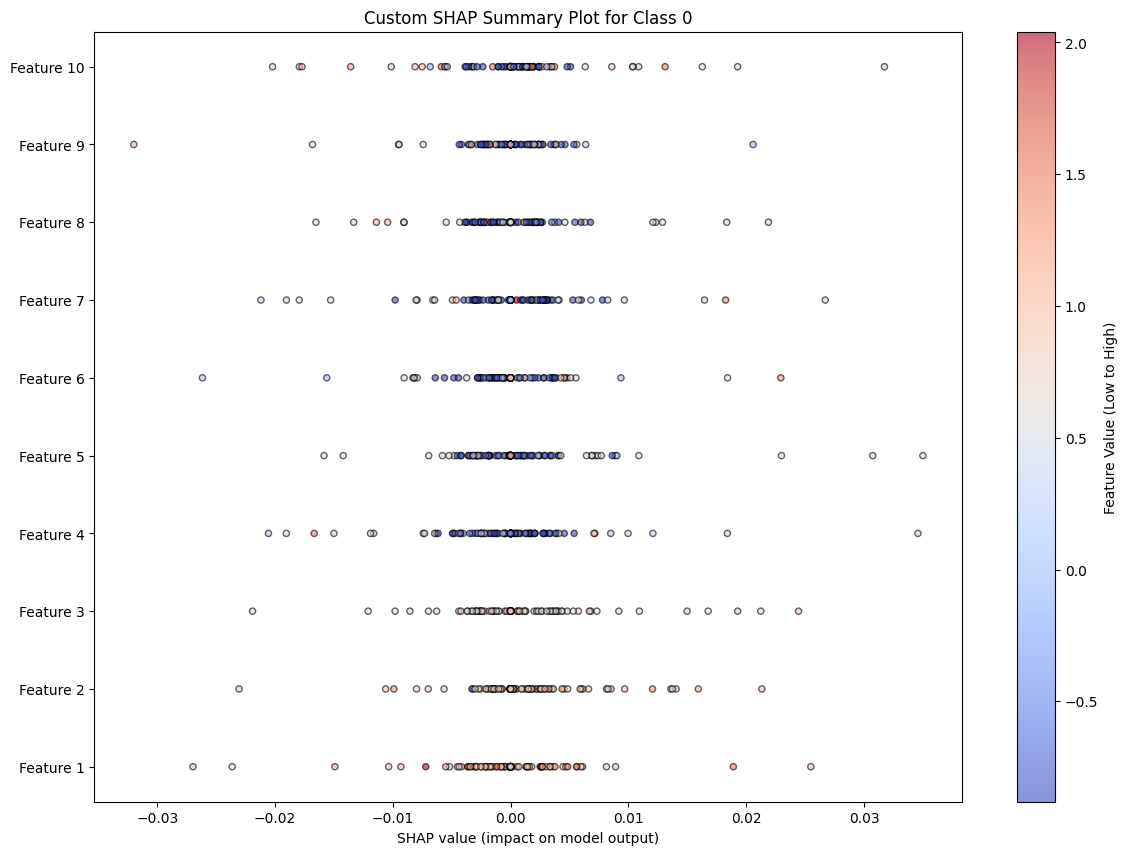

In [29]:
import matplotlib.pyplot as plt

# Select the SHAP values for the first output (e.g., class 0)
feature_shap_values = shap_values[:, :10, 0]  # Choose the first 10 features for class 0
feature_values = sample_df.iloc[:, :10].values

# Check the shapes after selecting the first output to ensure consistency
print("Adjusted Feature SHAP values shape:", feature_shap_values.shape)
print("Feature values shape:", feature_values.shape)

# Custom scatter plot for SHAP values
plt.figure(figsize=(14, 10))
for i, (shap_vals, feat_vals) in enumerate(zip(feature_shap_values.T, feature_values.T)):
    plt.scatter(shap_vals, [i] * len(shap_vals), alpha=0.6, c=feat_vals, cmap='coolwarm', s=20, edgecolor='k')

plt.yticks(range(len(sample_df.columns[:10])), sample_df.columns[:10])
plt.xlabel("SHAP value (impact on model output)")
plt.colorbar(label="Feature Value (Low to High)")
plt.title("Custom SHAP Summary Plot for Class 0")
plt.show()


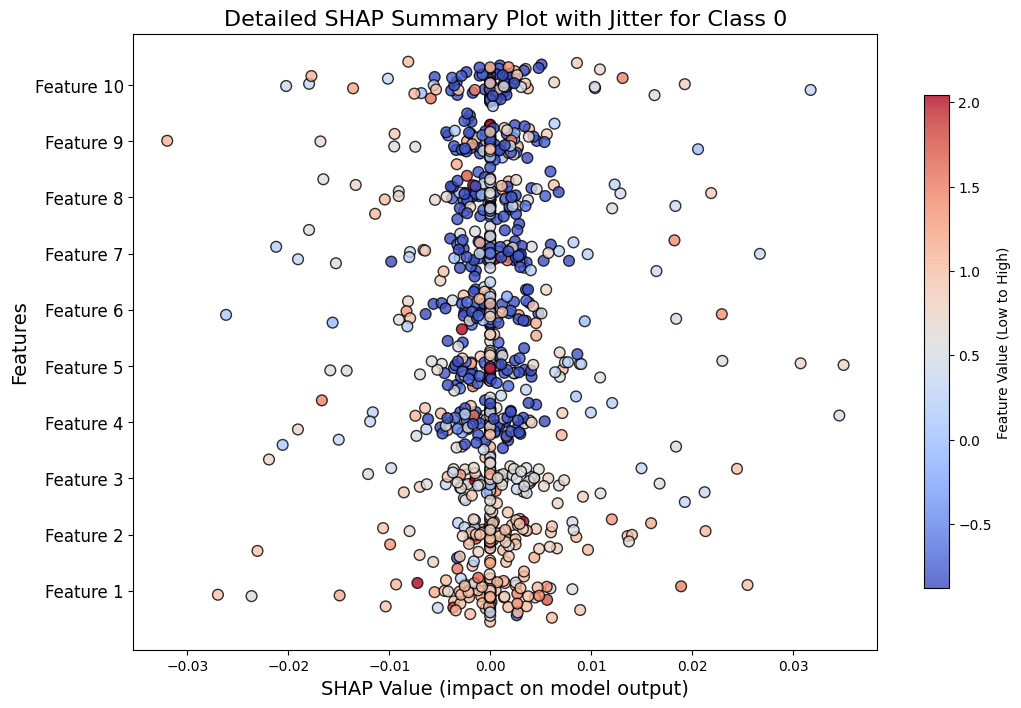

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Define a more spread-out jitter and a better colormap
jitter_strength = 0.2  # Increase jitter for more spread
colormap = 'coolwarm'  # Use a continuous colormap

# Create a figure
plt.figure(figsize=(12, 8))

# Loop through features and SHAP values for scatter plot
for i, (shap_vals, feat_vals) in enumerate(zip(feature_shap_values.T, feature_values.T)):
    jitter = np.random.normal(0, jitter_strength, size=len(shap_vals))  # Add random noise
    scatter = plt.scatter(shap_vals, [i + jitter_val for jitter_val in jitter],
                          alpha=0.8, c=feat_vals, cmap=colormap, s=60, edgecolor='k', marker='o')

# Improve x and y labels
plt.xlabel("SHAP Value (impact on model output)", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.yticks(range(10), sample_df.columns[:10], fontsize=12)
plt.title("Detailed SHAP Summary Plot with Jitter for Class 0", fontsize=16)

# Add colorbar with feature value scale
plt.colorbar(scatter, label="Feature Value (Low to High)", shrink=0.8)

# Show plot
plt.show()


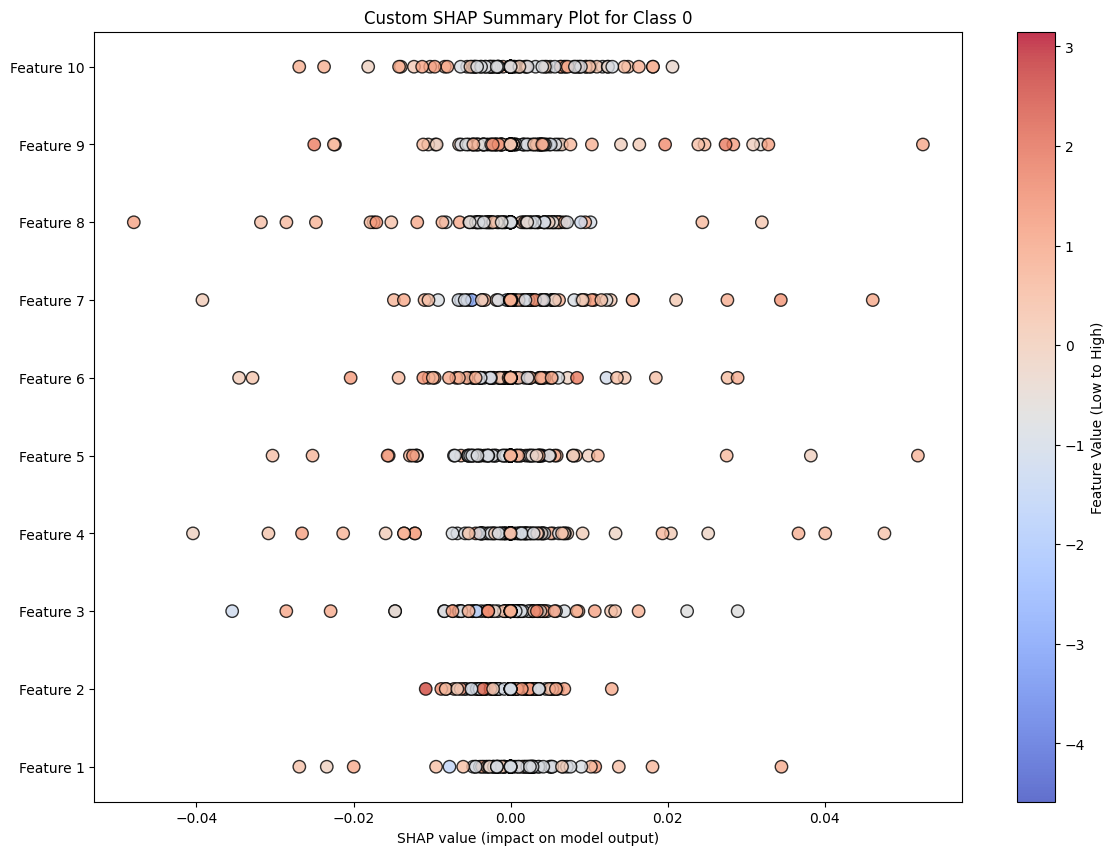

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Scale the SHAP values for better distribution of points
shap_scaled = feature_shap_values * 1.5  # Adjust this factor as needed to spread points

# Increase the size of dots and modify alpha for less transparency
scatter = plt.scatter(shap_scaled.flatten(),
                      np.repeat(range(10), len(shap_scaled)),
                      alpha=0.8,  # Increase alpha for darker color
                      c=feature_values.flatten(),
                      cmap='coolwarm',  # Use coolwarm color palette for contrast
                      s=80,  # Increase the dot size for better visibility
                      edgecolor='k')

# Label the y-ticks with feature names
plt.yticks(range(10), sample_df.columns[:10])

# Set x-axis and colorbar labels
plt.xlabel("SHAP value (impact on model output)")
plt.colorbar(scatter, label="Feature Value (Low to High)")

# Set plot title
plt.title("Custom SHAP Summary Plot for Class 0")

# Show the plot
plt.show()


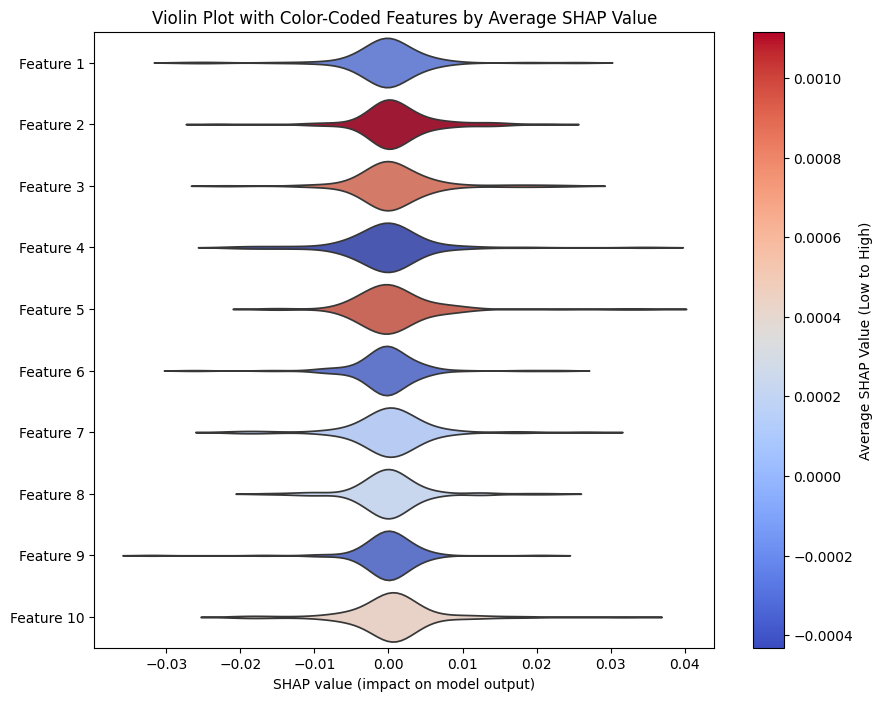

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean SHAP value for each feature and map it to the coolwarm colormap
mean_shap_values = feature_shap_values.mean(axis=0)
norm = plt.Normalize(vmin=mean_shap_values.min(), vmax=mean_shap_values.max())
colors = plt.cm.coolwarm(norm(mean_shap_values))
colors_list = [tuple(color) for color in colors]  # Convert to list of tuples for palette

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))
sns.violinplot(data=feature_shap_values, orient='h', inner=None, palette=colors_list, ax=ax)

ax.set_xlabel("SHAP value (impact on model output)")
ax.set_yticks(range(10))
ax.set_yticklabels(sample_df.columns[:10])
ax.set_title("Violin Plot with Color-Coded Features by Average SHAP Value")

# Add colorbar to the figure
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])  # Dummy array for ScalarMappable
fig.colorbar(sm, ax=ax, label="Average SHAP Value (Low to High)")

plt.show()
